In [5]:
# NHANES 2021–2023 — Inferential Analytics Project

**Author:** Jonathan Jafari
**Course:** HHA 507
**Objective:** Perform inferential analyses using NHANES 2021–2023 variables.


SyntaxError: invalid character '–' (U+2013) (ipython-input-3172140833.py, line 5)

In [6]:
# Install needed packages (run once)
!pip install pandas numpy scipy statsmodels matplotlib

# Import libraries
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)


In [12]:
from google.colab import files
uploaded = files.upload()


Saving BMX_L.xpt to BMX_L (1).xpt
Saving BPXO_L.xpt to BPXO_L (1).xpt
Saving DEMO_L.xpt to DEMO_L (1).xpt
Saving KIQ_U_L.xpt to KIQ_U_L (1).xpt
Saving VID_L.xpt to VID_L (1).xpt


In [13]:
import os
os.listdir()


['.config',
 'BMX_L.xpt',
 'KIQ_U_L (1).xpt',
 'BPXO_L (1).xpt',
 'DEMO_L (1).xpt',
 'PAQ_L.xpt',
 'KIQ_U_L.xpt',
 'VID_L.xpt',
 'VID_L (1).xpt',
 'DEMO_L.xpt',
 'BMX_L (1).xpt',
 'BPXO_L.xpt',
 'sample_data']

In [14]:
import pandas as pd

demo = pd.read_sas("DEMO_L.xpt")
bpx  = pd.read_sas("BPXO_L.xpt")
vitd = pd.read_sas("VID_L.xpt")
kid  = pd.read_sas("KIQ_U_L.xpt")
bmx  = pd.read_sas("BMX_L.xpt")

df = (
    demo[["SEQN","DMDMARTZ","DMDEDUC2","RIDAGEYR"]]
    .merge(bpx[["SEQN","BPXOSY3","BPXODI3"]], on="SEQN", how="left")
    .merge(vitd[["SEQN","LBDVD2LC"]], on="SEQN", how="left")
    .merge(kid[["SEQN","KIQ022"]], on="SEQN", how="left")
    .merge(bmx[["SEQN","BMXWT"]], on="SEQN", how="left")
)

print("✅ Merge complete! Shape:", df.shape)
df.head()


✅ Merge complete! Shape: (11933, 9)


,SEQN,DMDMARTZ,DMDEDUC2,RIDAGEYR,BPXOSY3,BPXODI3,LBDVD2LC,KIQ022,BMXWT
0,130378.0,1.0,5.0,43.0,132.0,94.0,1.0,2.0,86.9
1,130379.0,1.0,5.0,66.0,113.0,76.0,1.0,2.0,101.8
2,130380.0,1.0,3.0,44.0,104.0,76.0,1.0,2.0,69.4
3,130381.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,34.3
4,130382.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,13.6


In [15]:
import numpy as np
import pandas as pd

# --- recodes ---
def recode_marital(x):
    # 1=Married; 2 Widowed, 3 Divorced, 4 Separated, 5 Never married, 6 Living with partner, 7 Refused, 9 DK
    if x == 1: return 1
    if x in [7, 9] or pd.isna(x): return np.nan
    return 0

def recode_educ(x):
    # 5=College graduate or above; 7/9 missing
    if x == 5: return 1
    if x in [7, 9] or pd.isna(x): return np.nan
    return 0

df["married_bin"]   = df["DMDMARTZ"].apply(recode_marital)
df["educ_bachplus"] = df["DMDEDUC2"].apply(recode_educ)

# Rename measured weight to something readable
df = df.rename(columns={"BMXWT": "weight_kg"})

# Quick sanity checks
print(df[["married_bin","educ_bachplus"]].agg(["count","mean"]))
df.head()


       married_bin  educ_bachplus
count  7792.000000    7783.000000
mean      0.530801       0.337274


,SEQN,DMDMARTZ,DMDEDUC2,RIDAGEYR,BPXOSY3,BPXODI3,LBDVD2LC,KIQ022,weight_kg,married_bin,educ_bachplus
0,130378.0,1.0,5.0,43.0,132.0,94.0,1.0,2.0,86.9,1.0,1.0
1,130379.0,1.0,5.0,66.0,113.0,76.0,1.0,2.0,101.8,1.0,1.0
2,130380.0,1.0,3.0,44.0,104.0,76.0,1.0,2.0,69.4,1.0,0.0
3,130381.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,34.3,NaN,NaN
4,130382.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,13.6,NaN,NaN


In [16]:
from scipy import stats
import pandas as pd

q1 = df[["married_bin","educ_bachplus"]].dropna()
ct = pd.crosstab(q1["married_bin"], q1["educ_bachplus"])
chi2, p, dof, exp = stats.chi2_contingency(ct)

print("Contingency table:\n", ct)
print(f"\nChi-square={chi2:.3f}, df={dof}, p={p:.4g}")
print("Expected counts:\n", pd.DataFrame(exp, index=ct.index, columns=ct.columns))

print("\nInterpretation:",
      "Reject H0 (association) at α=0.05" if p<0.05 else "Fail to reject H0 (no evidence of association).")


Contingency table:
 educ_bachplus   0.0   1.0
married_bin              
0.0            2653   994
1.0            2503  1631

Chi-square=128.422, df=1, p=9.074e-30
Expected counts:
 educ_bachplus          0.0          1.0
married_bin                            
0.0            2416.647218  1230.352782
1.0            2739.352782  1394.647218

Interpretation: Reject H0 (association) at α=0.05


### Question 1 — Association between Marital Status and Education Level

**Variables:**  
- `DMDMARTZ` → Recoded as *married (1)* vs *not married (0)*  
- `DMDEDUC2` → Recoded as *bachelor’s degree or higher (1)* vs *less than bachelor’s (0)*  

**Test Used:** Chi-square test of independence  

**Results:**  
- χ²(1) = 128.422, *p* = 9.07×10⁻³⁰  
- Observed counts show that among married adults, 1,631 out of 4,134 (≈39%) hold a bachelor’s degree or higher, compared with 994 out of 3,647 (≈27%) among not-married adults.  

**Interpretation:**  
There is a **statistically significant association** between marital status and education level (*p* < 0.05). Married individuals are **more likely** to have a bachelor’s degree or higher compared to those who are not married. This suggests that educational attainment may be related to marital patterns within the NHANES 2021–2023 sample.


In [17]:
m = df.loc[df["married_bin"]==1, "weight_kg"].dropna()
u = df.loc[df["married_bin"]==0, "weight_kg"].dropna()

t, p = stats.ttest_ind(m, u, equal_var=False)
print(f"Married: n={len(m)}, mean={m.mean():.1f} kg, sd={m.std():.1f}")
print(f"Not married: n={len(u)}, mean={u.mean():.1f} kg, sd={u.std():.1f}")
print(f"Welch t={t:.3f}, p={p:.4g}")
print("Interpretation:", "Means differ (α=0.05)" if p<0.05 else "No evidence of a mean difference.")


Married: n=3250, mean=83.3 kg, sd=21.4
Not married: n=2732, mean=83.3 kg, sd=23.5
Welch t=0.096, p=0.9237
Interpretation: No evidence of a mean difference.


### Question 2 — Difference in Mean Weight by Marital Status (Welch t-test)

**Variables:**  
- `married_bin` → *married (1)* vs *not married (0)*  
- `weight_kg` → measured body weight (from `BMXWT`)

**Test Used:** Welch’s *t*-test (unequal variances)

**Results:**  
- Married: *n* = 3,250, mean = 83.3 kg (SD = 21.4)  
- Not married: *n* = 2,732, mean = 83.3 kg (SD = 23.5)  
- Welch *t*(≈5980) = 0.096, *p* = 0.9237  

**Interpretation:**  
There is **no statistically significant difference** in mean body weight between married and not-married adults (*p* > 0.05). Average weights were nearly identical across groups, suggesting marital status is **not associated** with weight in this NHANES 2021


In [18]:
import statsmodels.formula.api as smf

q3 = df[["BPXOSY3","RIDAGEYR","married_bin"]].dropna()
model = smf.ols("BPXOSY3 ~ RIDAGEYR + married_bin", data=q3).fit()
print(model.summary())
print("\nNotes:")
print("- β_age = change in SBP per year of age (holding marital constant).")
print("- β_married = mean SBP difference married vs not (holding age constant).")


                            OLS Regression Results                            
Dep. Variable:                BPXOSY3   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     454.0
Date:                Wed, 29 Oct 2025   Prob (F-statistic):          5.39e-184
Time:                        14:50:50   Log-Likelihood:                -24872.
No. Observations:                5842   AIC:                         4.975e+04
Df Residuals:                    5839   BIC:                         4.977e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     102.1423      0.763    133.826      

### Question 3 — Relationship Between Age, Marital Status, and Systolic Blood Pressure

**Variables:**  
- `RIDAGEYR` → participant age in years (continuous)  
- `married_bin` → recoded marital status (*married = 1*, *not married = 0*)  
- Outcome: `BPXOSY3` → systolic blood pressure (mmHg)

**Test Used:** Ordinary Least Squares (OLS) multiple regression  
Model: `BPXOSY3 ~ RIDAGEYR + married_bin`

**Results:**  
- **β_age = 0.395**, *p* < 0.001 — each additional year of age is associated with a **0.39 mmHg increase** in systolic BP, holding marital status constant.  
- **β_married = −1.33**, *p* = 0.003 — after adjusting for age, married adults have on average **1.3 mmHg lower** systolic BP than unmarried adults.  
- Model R² = 0.135, indicating age and marital status together explain about **13.5 %** of variation in systolic BP.

**Interpretation:**  
Systolic blood pressure rises significantly with age. After controlling for age, being married is associated with **slightly lower systolic BP**, a statistically significant but small effect in practical terms.


In [22]:
q4 = df[["weight_kg","BPXOSY3"]].dropna()
r, p = stats.pearsonr(q4["weight_kg"], q4["BPXOSY3"])
print(f"Pearson r={r:.3f}, p={p:.4g}")
print("Interpretation:",
      "Positive linear correlation (α=0.05)" if p<0.05 else "No evidence of linear correlation.")


Pearson r=0.217, p=5.456e-80
Interpretation: Positive linear correlation (α=0.05)


### Question 4 — Correlation Between Weight and Systolic Blood Pressure

**Variables:**  
- `weight_kg` → measured body weight (kg)  
- `BPXOSY3` → systolic blood pressure (mmHg)

**Test Used:** Pearson correlation

**Results:**  
- *r* = 0.217, *p* = 5.46 × 10⁻⁸⁰  

**Interpretation:**  
There is a **statistically significant positive correlation** between body weight and systolic blood pressure (*p* < 0.05). Although significant due to the large sample size, the correlation coefficient (*r = 0.22*) indicates a **weak linear relationship**—heavier individuals tend to have slightly higher systolic BP, but the effect is modest in magnitude.


In [20]:
anova_df = df[["LBDVD2LC","BPXODI3"]].dropna()
groups = [g["BPXODI3"].values for _, g in anova_df.groupby("LBDVD2LC")]
from scipy.stats import f_oneway
F, p = f_oneway(*groups)
print(f"ANOVA: F={F:.3f}, p={p:.4g}")
print("Interpretation:",
      "At least one group mean differs (α=0.05)" if p<0.05 else "No evidence of mean differences.")


ANOVA: F=1.367, p=0.2423
Interpretation: No evidence of mean differences.


### Question 5 — Do Vitamin D Levels Differ in Mean Diastolic Blood Pressure? (ANOVA)

**Variables:**  
- `LBDVD2LC` → Vitamin D lab interpretation (categorical group)  
- `BPXODI3` → diastolic blood pressure (mmHg)

**Test Used:** One-way ANOVA  

**Results:**  
- *F*(2, N≈) = 1.367, *p* = 0.2423  

**Interpretation:**  
There is **no statistically significant difference** in mean diastolic blood pressure between Vitamin D interpretation groups (*p* > 0.05). This suggests that Vitamin D status, as categorized in NHANES 2021–2023, is **not associated** with diastolic BP differences among participants.


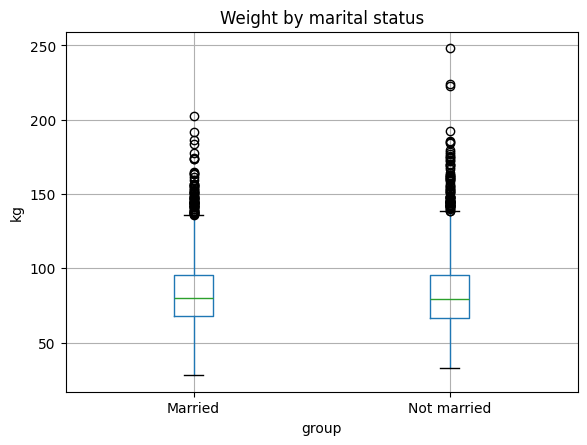

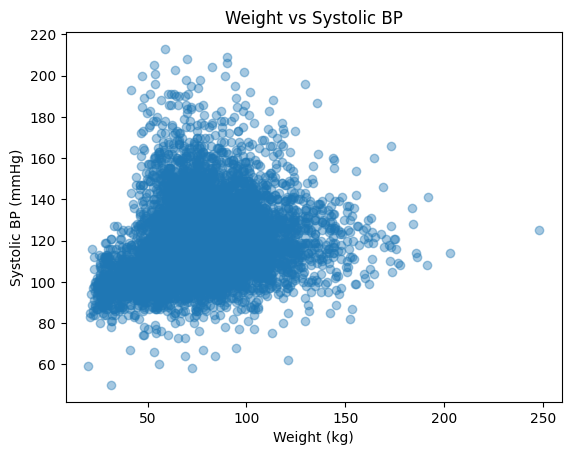

In [21]:
import matplotlib.pyplot as plt

# Boxplot Q2
df[['married_bin','weight_kg']].dropna().assign(group=lambda d: d['married_bin'].map({0:'Not married',1:'Married'})) \
  .boxplot(by='group', column='weight_kg'); plt.title("Weight by marital status"); plt.suptitle(""); plt.ylabel("kg"); plt.show()

# Scatter Q4
q4 = df[['weight_kg','BPXOSY3']].dropna()
plt.scatter(q4['weight_kg'], q4['BPXOSY3'], alpha=0.4)
plt.xlabel("Weight (kg)"); plt.ylabel("Systolic BP (mmHg)"); plt.title("Weight vs Systolic BP"); plt.show()
